# Visualization of the neuronal network

## Preparing the environment

In [1]:
#Importing the necessary libraries
import math
import trimesh
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from glob import glob
from PIL import Image
import cv2
import json
from os import walk
from tqdm import tqdm
from datetime import datetime
import multiprocessing as mp
import re

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing as pp

import skimage.io
import skimage.color

# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from tensorflow_addons.metrics import RSquare
from keras import optimizers, models, layers, regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Input, Lambda, Flatten
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from keras.utils.np_utils import to_categorical

import matplotlib.patches as patches
import cv2

#!pip install keract
from keract import get_activations
from keract import display_activations
from keract import display_heatmaps

2023-07-17 12:39:19.500051: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-17 12:39:20.121159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 12:39:34.695481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/kit/stud/uwilm/.local/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode u

## Data with glare points

### Loading the data

In [2]:
# Define a helper function that takes a subdirectory name and returns the image and label
def process_subdirectory(path):
    size=512
    obj_path = path[0]
    subdirectory = path[1]
    image = None
    label = None
    readed = lambda image_name: np.asarray(Image.open(image_name).convert("RGB"))
    random_number=np.random.randint(0,36)*10
    # We found out that image '0304/220_0_00.png' is faulty, therefore it will be excluded
    while (subdirectory) == ('0304') and random_number == 220:
        random_number=np.random.randint(0,36)*10
    for i_image in os.listdir(obj_path+'/'+subdirectory):
        PATH = os.path.join(obj_path+'/'+subdirectory,i_image)
        if i_image==(str(random_number)+'_0_00.png'):        
            #read a random representation of each droplet
            img_loop = readed(PATH)
            # Resizing image if needed:
            # img_loop = cv2.resize(img_loop, (size,size))
            # Normalizing the colors
            #-----------------------------------------------------------------------
            # RGB (Red, Green, Blue) are 8 bit each and the range for each individual 
            # colour is 0-255 (2^8 = 256). By dividing by 255, the 0-255 range is converted to
            # a range between 0.0-1.0.
            #-----------------------------------------------------------------------
            image = np.array(img_loop)/255.
            label = subdirectory+'/'+i_image.replace('.png','')
            break
    return image, label

# Creating a function to read the images from the files:
def image_reader(obj_path):      
    images = []
    labels = []
    # Create a pool 
    pool = mp.Pool(mp.cpu_count())
    print(f"Using all {mp.cpu_count()} processor cores to parallelize task.")
    # Use imap to apply your function to each subdirectory and get an iterator of results
    subdirs = os.listdir(obj_path)
    results = tqdm(pool.imap(process_subdirectory, zip([obj_path] * len(subdirs), subdirs)), total = len(subdirs))
    # Iterate over the results and append them to the output lists
    for image, label in results:
        images.append(image)
        labels.append(label)
    return images, labels

#Read y_data from json file (contains data extracted from .obj files with trimesh script)
def read_json_data(filename):
    f = open(filename)
    data = json.load(f)
    return data

In [3]:
# Reading the images
image_data, label_data = image_reader('/pfs/work7/workspace/scratch/oy0026-DDE2_droplet/RENDER/')
image_data = np.array(image_data)
label_data = np.array(label_data)
print(image_data.shape)

Using all 80 processor cores to parallelize task.


100%|██████████| 1479/1479 [00:13<00:00, 110.03it/s]


(1479, 512, 512, 3)


In [4]:
# Sorting the data, as labels show that data is unsorted so far
sortedIndices = np.argsort(label_data)
sorted_labels = label_data[sortedIndices]
sorted_images = image_data[sortedIndices]

# For access over Visual Studio code, one has to move the directory to the git folder.
#if os.getcwd().split("/")[-1] != "dde2_project":
#    os.chdir("./dde2_project")
    
labeled_y_data = read_json_data('parameter_data.json')
y_data=[]
for key, value in labeled_y_data.items(): # keys are already sorted in json 
    y_data.append(value)
y_data=np.array(y_data)
print(y_data.shape)

(1479, 23)


In [5]:
y_data=pd.DataFrame(y_data)

y_data.rename(columns = {0:'Volume', 1:'Area', 2:'x centroid' , 3:'y centroid' , 4:'z centroid', 5:'Contact Angle', 6:'shadowed area', 7:'perimeter', 8:'w', 9:'skewness',
                         10:'kurtosis', 11:'max pit height', 12:'max peak height', 13:'aspect ratio', 14:'theta', 15:'point aspect ratio', 16:'hull ratio',
                         17:'moment 2 x', 18:'moment 2 z', 19:'moment 3 x', 20:'moment 3 z', 21:'moment 4 x', 22:'moment 4 z'}, inplace = True)

y_data['compactness']=y_data['perimeter']/y_data['shadowed area']

In [6]:
# "repair" other nan values
# nan values always occure, when the droplet does not touch the ground
# find nan positions
nan_angle_ind = y_data['Contact Angle'].isna()
nan_ind_z = y_data['z centroid'].isna()
nan_ind_shadow = y_data['shadowed area'].isna()
nan_ind_perimeter = y_data['perimeter'].isna()
nan_ind_w = y_data['w'].isna()
nan_ind_skewness = y_data['skewness'].isna()
nan_ind_kurtosis = y_data['kurtosis'].isna()
nan_ind_pit = y_data['max pit height'].isna()
nan_ind_peak = y_data['max peak height'].isna()
nan_ind_aspect = y_data['aspect ratio'].isna()
nan_ind_theta = y_data['theta'].isna()
nan_ind_point = y_data['point aspect ratio'].isna()
nan_ind_hull = y_data['hull ratio'].isna()
nan_ind_2x = y_data['moment 2 x'].isna()
nan_ind_2z = y_data['moment 2 z'].isna()
nan_ind_3x = y_data['moment 3 x'].isna()
nan_ind_3z = y_data['moment 3 z'].isna()
nan_ind_4x = y_data['moment 4 x'].isna()
nan_ind_4z = y_data['moment 4 z'].isna()

# set new value
y_data["Contact Angle"][nan_angle_ind]=-1
y_data["z centroid"][nan_ind_z]=-1
y_data["shadowed area"][nan_ind_shadow]=0
y_data["perimeter"][nan_ind_perimeter]=0
y_data["w"][nan_ind_w]=-1
y_data["skewness"][nan_ind_skewness]=0
y_data["kurtosis"][nan_ind_kurtosis]=0
y_data["max pit height"][nan_ind_pit]=-1
y_data["max peak height"][nan_ind_peak]=-1
y_data["aspect ratio"][nan_ind_aspect]=0
y_data["theta"][nan_ind_theta]=-1
y_data["point aspect ratio"][nan_ind_point]=0
y_data["hull ratio"][nan_ind_hull]=0
y_data["moment 2 x"][nan_ind_2x]=-1
y_data["moment 2 z"][nan_ind_2z]=-1
y_data["moment 3 x"][nan_ind_3x]=-4000
y_data["moment 3 z"][nan_ind_3z]=-4000
y_data["moment 4 x"][nan_ind_4x]=-1
y_data["moment 4 z"][nan_ind_4z]=-1
y_data["compactness"][nan_ind_4z]=0

y_data.isna().sum()

Volume                0
Area                  0
x centroid            0
y centroid            0
z centroid            0
Contact Angle         0
shadowed area         0
perimeter             0
w                     0
skewness              0
kurtosis              0
max pit height        0
max peak height       0
aspect ratio          0
theta                 0
point aspect ratio    0
hull ratio            0
moment 2 x            0
moment 2 z            0
moment 3 x            0
moment 3 z            0
moment 4 x            0
moment 4 z            0
compactness           0
dtype: int64

In [7]:
#Select relevant data and rescale so that they are normalized 
featuresToScale = ['Volume','Area', 'y centroid','Contact Angle', 'shadowed area', 'perimeter', 'compactness', 'w', 'skewness', 'kurtosis', 'max pit height', 'max peak height', 'aspect ratio', 
                   'theta', 'point aspect ratio', 'hull ratio', 'moment 2 x', 'moment 2 z', 'moment 3 x', 'moment 3 z']
sY = pp.StandardScaler(copy=True)
y_data_rel = pd.DataFrame(np.vstack((y_data['Volume'].values,y_data['Area'].values,y_data['y centroid'].values,y_data['Contact Angle'].values,y_data['shadowed area'].values,
                                     y_data['perimeter'].values, y_data['compactness'].values,y_data['w'].values,y_data['skewness'].values,y_data['kurtosis'].values,y_data['max pit height'].values,
                                     y_data['max peak height'].values,y_data['aspect ratio'].values,y_data['theta'].values,y_data['point aspect ratio'].values,y_data['hull ratio'].values,
                                     y_data['moment 2 x'].values,y_data['moment 2 z'].values,y_data['moment 3 x'].values,y_data['moment 3 z'].values)).T,columns=featuresToScale)
y_data_rel.loc[:,featuresToScale] = sY.fit_transform(y_data_rel[featuresToScale])
#Looking into the statistics again:
y_data_rel.describe()

,Volume,Area,y centroid,Contact Angle,shadowed area,perimeter,compactness,w,skewness,kurtosis,max pit height,max peak height,aspect ratio,theta,point aspect ratio,hull ratio,moment 2 x,moment 2 z,moment 3 x,moment 3 z
count,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03,1.479000e+03
mean,-1.537347e-16,-3.459032e-16,-1.921684e-17,2.306021e-16,-1.921684e-16,-5.765053e-17,3.062684e-17,-8.167158e-17,1.056926e-16,-6.245474e-17,1.921684e-17,-1.921684e-17,-1.153011e-16,-1.489305e-16,1.921684e-16,3.074695e-16,7.686737e-17,-1.153011e-16,-1.153011e-16,-2.402105e-18
std,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00
min,-6.874815e-01,-1.144348e+00,-1.002473e+00,-2.170029e+00,-1.694178e+00,-2.333119e+00,-1.057120e+00,-1.318513e+00,-2.716981e+00,-1.513638e+00,-1.256625e+00,-1.033669e+00,-2.788718e+00,-1.705671e+00,-2.740138e+00,-2.933010e+00,-1.721706e+00,-1.605598e+00,-3.133593e+00,-2.392878e+00
25%,-6.795408e-01,-7.549959e-01,-4.718951e-01,-4.836391e-01,-4.607467e-01,-1.753623e-01,-2.301106e-01,-7.601638e-01,-1.514470e-02,-2.442470e-01,-7.518394e-01,-8.021893e-01,4.415666e-02,-1.065565e+00,-2.838721e-02,3.283058e-01,-5.480609e-01,-4.778856e-01,-2.356266e-01,-5.778547e-02
50%,-6.724024e-01,-2.468686e-01,-4.333881e-01,1.521032e-01,-9.261943e-02,1.589343e-01,-2.353469e-02,-3.094094e-01,2.476964e-01,4.707533e-02,-2.112275e-01,-4.338603e-01,1.579192e-01,-4.844825e-02,1.246044e-01,3.473834e-01,1.664062e-01,-3.339723e-01,1.537833e-01,-4.584931e-02
75%,1.470838e+00,3.716910e-01,1.163597e-01,1.032604e+00,4.935721e-01,5.235239e-01,6.262713e-02,1.187369e+00,3.885075e-01,2.046867e-01,8.988402e-01,5.238328e-01,6.493158e-01,9.357072e-01,7.119270e-01,3.510417e-01,2.969752e-01,7.408499e-01,2.546588e-01,2.394585e-01
max,1.488785e+00,3.421671e+00,3.043535e+00,3.450635e+00,3.019371e+00,1.857141e+00,2.003597e+01,3.502016e+00,5.744070e+00,2.657874e+01,4.368124e+00,2.055440e+00,2.668738e+00,9.366731e-01,2.306350e+00,3.510417e-01,2.376871e+00,3.510499e+00,2.871323e+00,3.298018e+00


In [8]:
# As the image values are already between 0 and 1 one the X-matrix does not need to be scaled
X = sorted_images
y = y_data_rel.copy()
print(y.shape)
seed = 2023
X, y = shuffle(X, y, random_state = seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1479, 20)
(1331, 512, 512, 3) (148, 512, 512, 3)
(1331, 20) (148, 20)


### Loading the neuronal network

In [9]:
def build_model_CNN():
    # input array shape for the network:
    input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
    #Here we will use Sequential API like we did in MLP
    model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", input_shape=input_shape, name="conv1"),
    MaxPooling2D((2, 2), name="maxPooling1"),
    Conv2D(64, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv2"),
    MaxPooling2D((2, 2), name="maxPooling2"),
    Conv2D(128, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv3"),
    MaxPooling2D((2, 2), name="maxPooling3"),
    Flatten(name="flatten"),
    
    Dense(20, activation="linear", name="dense1")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = "mse", metrics=["mae", RSquare()]) 

    return model

In [10]:
model = build_model_CNN()
model.load_weights("best_model_norm.h5")
model.summary()

2023-07-17 12:40:30.314084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30892 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 512, 512, 32)      896       
                                                                 
 maxPooling1 (MaxPooling2D)  (None, 256, 256, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 256, 256, 64)      18496     
                                                                 
 maxPooling2 (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 conv3 (Conv2D)              (None, 128, 128, 128)     73856     
                                                                 
 maxPooling3 (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 flatten (Flatten)           (None, 524288)            0

### choose test pictures

In [11]:
n_pic = [0,300,500,750,1000,1250]
ims = []
for i in n_pic:
    ims.append(X[i])

ims = np.array(ims)
print(ims.shape)

(6, 512, 512, 3)


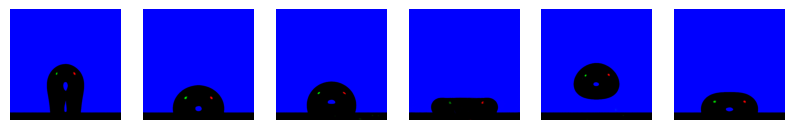

In [12]:
leng=len(ims)
fig,ax=plt.subplots(1,leng,figsize=(10,3))
for i in range(leng):
    ax[i].imshow(ims[i,:,:,:])
    ax[i].set_frame_on(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### Building the inverse model

For the visualization of the information, that is used in the different layers, the code of the following repository is used.

https://github.com/fejesmate/deconv_vis/blob/master/VGG16_vis_FejesMate.ipynb

That work is based on this paper:

[Zeiler, Matthew D., and Rob Fergus (2014). "Visualizing and understanding convolutional networks."](https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53)

In [13]:
def build_inverse_model():
    model = Sequential([
    Dense(524288, activation="linear", input_shape=(20,), name="dense1"),
    Reshape((64,64,128), name="reshape"),
    UpSampling2D((2, 2), name="UpSampling3"),
    Conv2DTranspose(64, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv3"),
    UpSampling2D((2, 2), name="UpSampling2"),
    Conv2DTranspose(32, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv2"),
    UpSampling2D((2, 2), name="UpSampling1"),
    Conv2DTranspose(3, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv1")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = "mse", metrics=["mae", RSquare()]) 
    
    return model

In [14]:
build_model_CNN().summary()
build_inverse_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 512, 512, 32)      896       
                                                                 
 maxPooling1 (MaxPooling2D)  (None, 256, 256, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 256, 256, 64)      18496     
                                                                 
 maxPooling2 (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 conv3 (Conv2D)              (None, 128, 128, 128)     73856     
                                                                 
 maxPooling3 (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 flatten (Flatten)           (None, 524288)           

In [15]:
inv_model = build_inverse_model()

In [16]:
# getting weights for all layers from original network
# convolutional layer
for i in range(1,4,1): #conv layers 1,2...13
    wf=model.get_layer('conv'+str(i)).get_weights()
    wi=wf #no need for transposing weights, because of transpose conv layer
    wi[1]=np.dot(wf[0].sum(axis=(0,1)),wf[1])#[:,0]  #inverse offset weights
    wi[1]=np.zeros(wi[1].shape) #if we want 0 bias in the inverse model
    
    inv_model.get_layer('conv'+str(i)).set_weights(wi)
    
# dense layer
for i in range(1,1,1): #dense layers 1,2,3
    wf=model.get_layer('dense'+str(i)).get_weights()
    wi=wf
    wi[0]=wf[0].transpose()
    wi[1]=np.dot(wf[0].transpose(),np.expand_dims(wf[1], axis=0).transpose())[:,0] #inverse offset weights
    wi[1]=np.zeros(wi[1].shape) #if we want 0 bias in the inverse model
    
    inv_model.get_layer('dense'+str(i)).set_weights(wi)
    
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss = "mse", metrics=["mae", RSquare()]) 

inv_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 524288)            11010048  
                                                                 
 reshape (Reshape)           (None, 64, 64, 128)       0         
                                                                 
 UpSampling3 (UpSampling2D)  (None, 128, 128, 128)     0         
                                                                 
 conv3 (Conv2DTranspose)     (None, 128, 128, 64)      73792     
                                                                 
 UpSampling2 (UpSampling2D)  (None, 256, 256, 64)      0         
                                                                 
 conv2 (Conv2DTranspose)     (None, 256, 256, 32)      18464     
                                                                 
 UpSampling1 (UpSampling2D)  (None, 512, 512, 32)     

In [17]:
# create dictionaries
conv_names=['conv'+str(i) for i in range(1,4,1)]

# creating dicts for layer name <-> layer sequence number
seq2name={}
name2seq={}
for i in range(8): #number of layers=8
    seq2name[i]=model.layers[i].get_config()['name']
    name2seq[seq2name[i]]=i

# creating dicts for inv layer name <-> inv layer sequence number
iseq2iname={}
iname2iseq={}
for i in range(8): #number of inv layers=8
    iseq2iname[i]=inv_model.layers[i].get_config()['name']
    iname2iseq[iseq2iname[i]]=i

### Restoring original picture based on feature maps in certain layers

In [18]:
def set_input_weights(inverse_part_model):
    #creating layer weights, that dont change anything when used (unclean solution for not being able to input data any other way to inverse sub model)
    ew_o=inverse_part_model.get_layer('just4input').get_weights()
    ew0=np.zeros(ew_o[0].shape)
    for i in range(ew_o[0].shape[-1]): #iterating over every kernel
        ew0[1,1,i,i]=1 #kernels, that recreate the original feature maps
    ew1=np.zeros(ew_o[1].shape)
    inverse_part_model.get_layer('just4input').set_weights((ew0,ew1))
    return inverse_part_model

def create_sub_inv_model(vis_layer,intermediate_output):
    #inverse sub-model: the part of the invers model between the examined layer and the output
    inv_sub_model = Sequential()
    chnumb=intermediate_output.shape[-1]
    inv_sub_model.add(Conv2D(chnumb, (3, 3), padding='same', name='just4input',input_shape=intermediate_output.shape[1:]))
    for layer in inv_model.layers[iname2iseq[vis_layer]:]:
        inv_sub_model.add(layer)
     
    return set_input_weights(inv_sub_model)

def restore_from_layer(vis_layer):
    sub_model = Model(inputs=model.input, outputs=model.get_layer(vis_layer).output)
    intermediate_output = sub_model.predict(ims)

    inv_sub_model=create_sub_inv_model(vis_layer,intermediate_output)

    pred=inv_sub_model.predict(intermediate_output)
    return norm_rgb(pred)

#normalize globally
def norm_rgb(rest_imgs):
    normed=np.zeros(rest_imgs.shape)
    
    for p in range(rest_imgs.shape[0]):
        mins=rest_imgs[p,:,:,:].min()
        maxs=rest_imgs[p,:,:,:].max()
        normed[p,:,:,:]=(rest_imgs[p,:,:,:]-mins)/(maxs-mins)
        
    return normed

In [19]:
# restoring images from every convolution layer with the inverse sub-models
conv_numb=len(conv_names)
all_conv_rest=np.zeros([conv_numb]+(list(ims.shape)))
for i in range(conv_numb):
    all_conv_rest[i,:,:,:,:]=restore_from_layer(conv_names[i])
    

2023-07-17 12:40:38.644878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


1/1 [==============================] - 0s 200ms/step


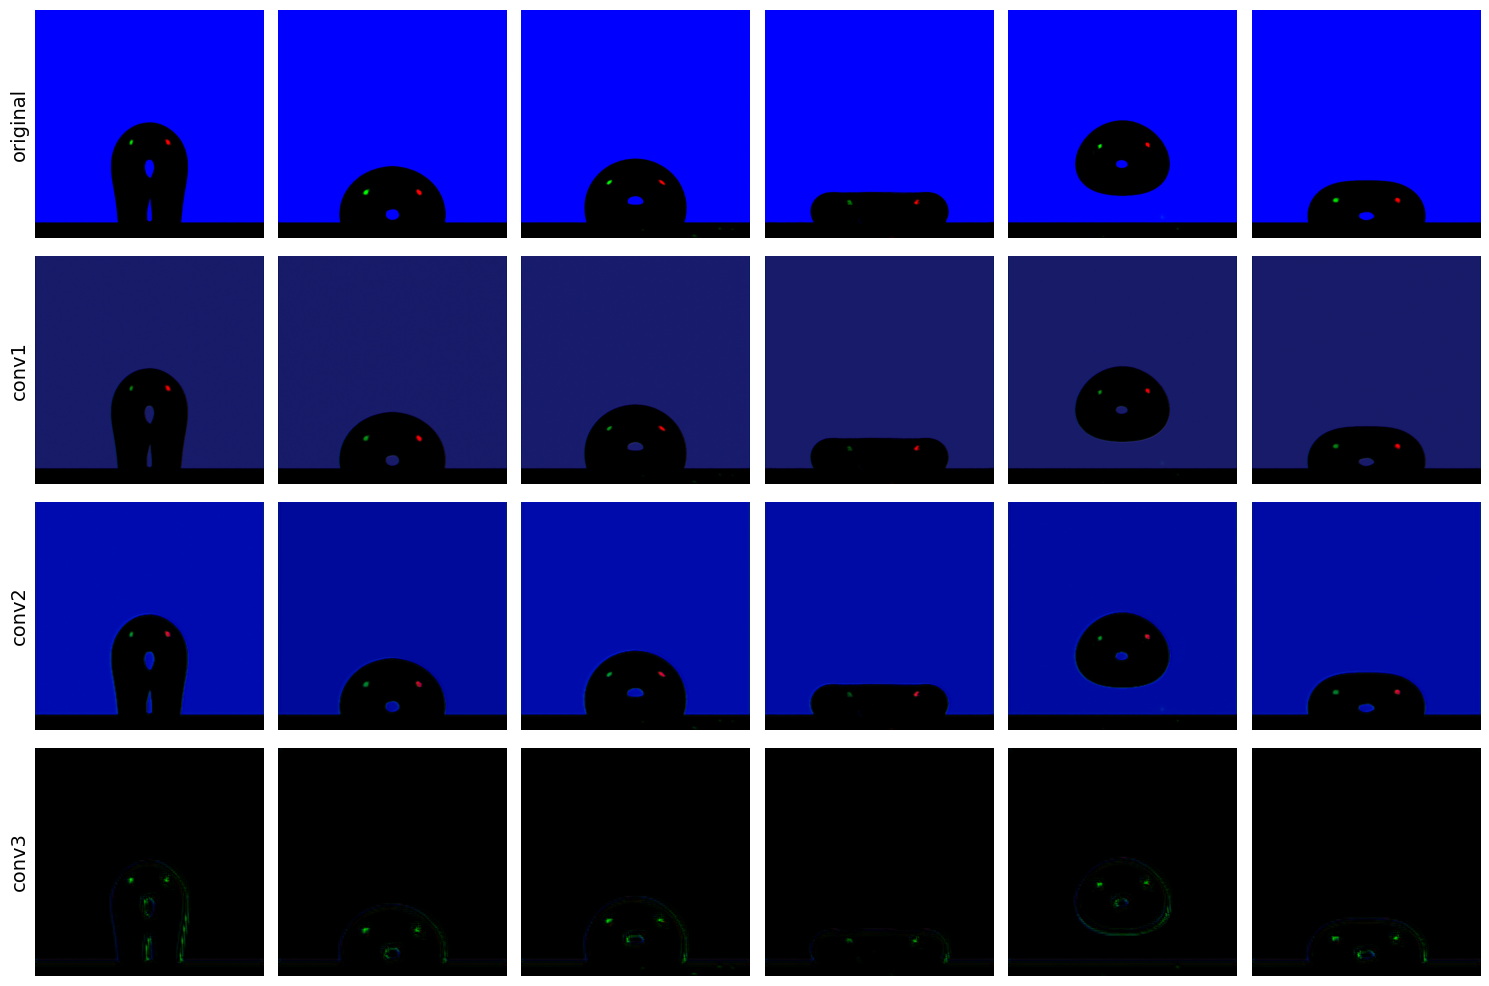

In [20]:
leng=len(ims)
fig,ax=plt.subplots(len(conv_names)+1,leng,figsize=(15,10),sharey=True)
for j in range(leng):

    ax[0,j].imshow((ims[j,:,:,:]))
    
    ax[0,j].set_frame_on(False)
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])

    if j==0:
        ax[0,j].set_ylabel('original', fontsize=14)
    
for i in range(conv_numb):
    for j in range(leng):
        
        ax[i+1,j].imshow(all_conv_rest[i,j,:,:,:])
        ax[i+1,j].set_frame_on(False)
        ax[i+1,j].set_xticks([])
        ax[i+1,j].set_yticks([])
        
        if j==0:
            ax[i+1,j].set_ylabel(conv_names[i], fontsize=14)

plt.tight_layout()
plt.savefig('heat_maps/reconstruct_withGP.png',dpi=300)
plt.show()

### Visualize activation

In [21]:
activations = get_activations(model, ims, auto_compile=True)
print(activations['conv1_input'][0,:,:,:].shape)
keys = activations.keys()

dict = {}
for k in keys:
    try:
        dict[k] = activations[k][1:2,:,:,:]
    except Exception:
        pass

print(dict.keys())

(512, 512, 3)
dict_keys(['conv1_input', 'conv1', 'maxPooling1', 'conv2', 'maxPooling2', 'conv3', 'maxPooling3'])


In [22]:
display_activations(dict, cmap=None, save=True, directory='./heat_maps/withGP', data_format='channels_last', fig_size=(128, 128), reshape_1d_layers=False)

conv1_input (1, 512, 512, 3) 
conv1 (1, 512, 512, 32) 
maxPooling1 (1, 256, 256, 32) 
conv2 (1, 256, 256, 64) 
maxPooling2 (1, 128, 128, 64) 
conv3 (1, 128, 128, 128) 
maxPooling3 (1, 64, 64, 128) 


## Data without glarepoints

### Preparing the data

In [23]:
# to remove glarepoints from droplet images we just set the r and g channel to zero, 
# for a more detailed description see get_angles_from_pictures
print(sorted_images.shape)
cropped_images = sorted_images.copy()
cropped_images[:, :, :, 0:2] = 0
print(cropped_images.shape)

print(sorted_images[0,0,0])
print(cropped_images[0,0,0])

sorted_images = cropped_images

(1479, 512, 512, 3)
(1479, 512, 512, 3)
[0.14117647 0.05882353 0.69019608]
[0.         0.         0.69019608]


In [24]:
# As the image values are already between 0 and 1 one the X-matrix does not need to be scaled
X = sorted_images
y = y_data_rel.copy()
print(y.shape)
seed = 2023
X, y = shuffle(X, y, random_state = seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1479, 20)
(1331, 512, 512, 3) (148, 512, 512, 3)
(1331, 20) (148, 20)


### Loading the neuronal network

In [25]:
def build_model_CNN():
    # input array shape for the network:
    input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
    #Here we will use Sequential API like we did in MLP
    model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", input_shape=input_shape, name="conv1"),
    MaxPooling2D((2, 2), name="maxPooling1"),
    Conv2D(64, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv2"),
    MaxPooling2D((2, 2), name="maxPooling2"),
    Conv2D(128, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv3"),
    MaxPooling2D((2, 2), name="maxPooling3"),
    Flatten(name="flatten"),
    
    Dense(20, activation="linear", name="dense1")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = "mse", metrics=["mae", RSquare()]) 

    return model

In [26]:
model = build_model_CNN()
model.load_weights("best_model_norm_wo_gp.h5")
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 512, 512, 32)      896       
                                                                 
 maxPooling1 (MaxPooling2D)  (None, 256, 256, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 256, 256, 64)      18496     
                                                                 
 maxPooling2 (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 conv3 (Conv2D)              (None, 128, 128, 128)     73856     
                                                                 
 maxPooling3 (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 flatten (Flatten)           (None, 524288)           

### choose test pictures

In [27]:
n_pic = [0,300,500,750,1000,1250]
ims = []
for i in n_pic:
    ims.append(X[i])

ims = np.array(ims)
print(ims.shape)

(6, 512, 512, 3)


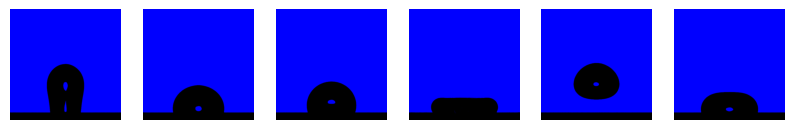

In [28]:
leng=len(ims)
fig,ax=plt.subplots(1,leng,figsize=(10,3))
for i in range(leng):
    ax[i].imshow(ims[i,:,:,:])
    ax[i].set_frame_on(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### Building the inverse model

In [29]:
def build_inverse_model():    
    model = Sequential([
    Dense(524288, activation="linear", input_shape=(20,), name="dense1"),
    Reshape((64,64,128), name="reshape"),
    UpSampling2D((2, 2), name="UpSampling3"),
    Conv2DTranspose(64, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv3"),
    UpSampling2D((2, 2), name="UpSampling2"),
    Conv2DTranspose(32, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv2"),
    UpSampling2D((2, 2), name="UpSampling1"),
    Conv2DTranspose(3, (3, 3), padding='same', activation="relu", kernel_initializer="he_uniform", name="conv1")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = "mse", metrics=["mae", RSquare()]) 
    
    return model

In [30]:
build_model_CNN().summary()
build_inverse_model().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 512, 512, 32)      896       
                                                                 
 maxPooling1 (MaxPooling2D)  (None, 256, 256, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 256, 256, 64)      18496     
                                                                 
 maxPooling2 (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 conv3 (Conv2D)              (None, 128, 128, 128)     73856     
                                                                 
 maxPooling3 (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 flatten (Flatten)           (None, 524288)           

In [31]:
inv_model = build_inverse_model()

In [ ]:
# getting weights for all layers from original network
# convolutional layer
for i in range(1,4,1): #conv layers 1,2...13
    wf=model.get_layer('conv'+str(i)).get_weights()
    wi=wf #no need for transposing weights, because of transpose conv layer
    wi[1]=np.dot(wf[0].sum(axis=(0,1)),wf[1])#[:,0]  #inverse offset weights
    wi[1]=np.zeros(wi[1].shape) #if we want 0 bias in the inverse model
    
    inv_model.get_layer('conv'+str(i)).set_weights(wi)
    
# dense layer
for i in range(1,1,1): #dense layers 1,2,3
    wf=model.get_layer('dense'+str(i)).get_weights()
    wi=wf
    wi[0]=wf[0].transpose()
    wi[1]=np.dot(wf[0].transpose(),np.expand_dims(wf[1], axis=0).transpose())[:,0] #inverse offset weights
    wi[1]=np.zeros(wi[1].shape) #if we want 0 bias in the inverse model
    
    inv_model.get_layer('dense'+str(i)).set_weights(wi)
    
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss = "mse", metrics=["mae", RSquare()]) 

inv_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 524288)            11010048  
                                                                 
 reshape (Reshape)           (None, 64, 64, 128)       0         
                                                                 
 UpSampling3 (UpSampling2D)  (None, 128, 128, 128)     0         


In [ ]:
# create dictionaries
conv_names=['conv'+str(i) for i in range(1,4,1)]

# creating dicts for layer name <-> layer sequence number
seq2name={}
name2seq={}
for i in range(8): #number of layers=8
    seq2name[i]=model.layers[i].get_config()['name']
    name2seq[seq2name[i]]=i

# creating dicts for inv layer name <-> inv layer sequence number
iseq2iname={}
iname2iseq={}
for i in range(8): #number of inv layers=8
    iseq2iname[i]=inv_model.layers[i].get_config()['name']
    iname2iseq[iseq2iname[i]]=i

### Restoring original picture based on feature maps in certain layers

In [ ]:
# restoring images from every convolution layer with the inverse sub-models
conv_numb=len(conv_names)
all_conv_rest=np.zeros([conv_numb]+(list(ims.shape)))
for i in range(conv_numb):
    all_conv_rest[i,:,:,:,:]=restore_from_layer(conv_names[i])
    

In [ ]:
leng=len(ims)
fig,ax=plt.subplots(len(conv_names)+1,leng,figsize=(15,10),sharey=True)
for j in range(leng):

    ax[0,j].imshow((ims[j,:,:,:]))
    #ax[0,j].imshow(cv2.cvtColor(np.float32(ims[j,:,:,:]), cv2.COLOR_BGR2RGB))
    
    ax[0,j].set_frame_on(False)
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])

    if j==0:
        ax[0,j].set_ylabel('original', fontsize=14)
    
for i in range(conv_numb):
    for j in range(leng):
        
        ax[i+1,j].imshow(all_conv_rest[i,j,:,:,:])
        ax[i+1,j].set_frame_on(False)
        ax[i+1,j].set_xticks([])
        ax[i+1,j].set_yticks([])
        
        if j==0:
            ax[i+1,j].set_ylabel(conv_names[i], fontsize=14)
#     ax[i].imshow(cv2.cvtColor(ims_v[i,:,:,:], cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.savefig('heat_maps/reconstruct_withoutGP.png',dpi=300)

### Visualize activation

In [ ]:
activations = get_activations(model, ims, auto_compile=True)
print(activations['conv1_input'][0,:,:,:].shape)
keys = activations.keys()

dict = {}
for k in keys:
    try:
        dict[k] = activations[k][1:2,:,:,:]
    except Exception:
        pass

print(dict.keys())

In [ ]:
display_activations(dict, cmap=None, save=True, directory='./heat_maps/withoutGP', data_format='channels_last', fig_size=(128, 128), reshape_1d_layers=False)